In [889]:
import pymysql
import ast
import pandas as pd
from shapely.geometry import shape, Polygon
from shapely.wkt import loads
import geopandas as gpd
import glob
import numpy as np
import ee
from datetime import datetime, timedelta
from scipy.interpolate import interp1d
import datetime as dt
from sklearn.linear_model import LinearRegression
from scipy.interpolate import interp1d
from pyproj import Geod
import matplotlib.pyplot as plt
import requests
from pathlib import Path
plt.style.use('ggplot')
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

In [99]:
ee.Initialize()

In [733]:
def ndviImage(image):
    ndvi = image.normalizedDifference(["B8", "B4"])
    return image.addBands(ndvi.rename("NDVI"))

def smooth_6(farm_sep, deg = 6):
    degree = deg  # nth degree polynomial
    x = np.array(range(len(farm_sep)))
    y = np.array(farm_sep)
    x_test = x
    X = np.array([x**i 
                     for i in range(degree + 1)]).T
    X_test = np.array([x_test**i 
                          for i in range(degree + 1)]).T
    regr = LinearRegression()

    regr.fit(X, y)

    return regr.predict(X_test)


def ihateclouds(df, k=2):
    series = df["NDVI"].values
    date = df["date"].values
    cloudless = series.copy()
    dfactor = 1

    for i in range(1, len(series)):
        if series[i] <= 0.30:
            index = i 
            while (series[index] <= 0.30 and 
                       ((date[i] 
                         - date[index]).astype('timedelta64[D]')
                        /np.timedelta64(1, 'D')) <= 15 and 
                       index >= 0):
                index = index - dfactor
                prev  = series[index]

            index = i + 1
            
            if index < len(series):
                next_val = series[index]
                while (series[index] <= series[i] and 
                           ((date[index] 
                             - date[i]).astype('timedelta64[D]')
                            /np.timedelta64(1,'D')) <= 15 and 
                           index < len(series) - 1):
                    index    = index + dfactor
                    next_val = series[index]
                cloudless[i] = (prev 
                                + next_val)/2
            else:
                cloudless[i] = prev

    def onlypeaks(series, k):
        if k == 0:
            return series

        peaks = series.copy()
        for i in range(1, len(series)):
            if ((series[i] 
                     - series[i - 1]) <= 0.5 and 
                    (series[i] 
                     - series[i - 1]) >= 0.01 and 
                    series[i - 1] > 0.3):
                peaks[i - 1] = np.nan

        nans, x = np.isnan(peaks), lambda z: z.nonzero()[0]
        peaks[nans] = np.interp(x(nans), 
                                   x(~nans), 
                                   peaks[~nans])

        return onlypeaks(peaks, k - 1)

    return onlypeaks(cloudless, k)

def get_df(feature):
    coordinates = feature['geometry']['coordinates']
    _id = feature['id']
    dates = feature['properties'].keys()
    ndvi = feature['properties'].values()
    df = pd.DataFrame()
    df['date'] = dates
    df['NDVI'] = ndvi
    df['id'] = _id
    df['coords'] = "_".join(np
                            .array(coordinates)
                            .astype(str))
    return df

get_df = np.vectorize(get_df)

def get_mean_ndvi(AOI, start_date, end_date) :
    dataset = (ee.ImageCollection("COPERNICUS/S2_SR")
           .filterBounds(AOI)
           .filterDate(start_date, end_date)
           .map(ndviImage)
           .select("NDVI"))

    timeseries_image = dataset.toBands()
    vectors = timeseries_image.sample(region = AOI, 
                                      scale = 10, 
                                      geometries = True)
    features = vectors.getInfo()['features']
    all_points_df = get_df(np.array(features))
    
    
    final_df = None
    final_df = pd.concat(all_points_df, 
                             ignore_index=True)
    final_df.date = (final_df.date.str[:8]
                     .apply(lambda x : datetime.strptime(str(x), "%Y%m%d")))
    final_df = final_df.loc[final_df.NDVI >= 0 ]
    
    point_ids = final_df['id'].unique()
    final_df_group = final_df.groupby('id')

    final_df_stat = final_df.groupby('date').mean().reset_index()
    final_df_stat['NDVI_IHC'] = ihateclouds(final_df_stat)
    final_df_stat['NDVI_SMOOTH'] = smooth_6(final_df_stat['NDVI_IHC'].values, 3)
    
    return final_df_stat

In [736]:

def inter_pol(df):
    
    y_interp = interp1d(df['days'], df['NDVI_SMOOTH'])
    st = []
    for i in range(df['days'].max()+1):
        
        st.append([i ,y_interp(i)])
        
    da = pd.DataFrame(st,columns = ['days','NDVI_SMOOTH'])
     
    da['NDVI_SMOOTH'] = da['NDVI_SMOOTH'].apply(lambda x:np.round(x,3))
    
    return da




In [1]:
df = pd.read_csv('/home/satyukt/Projects/5020/data/info/all_info.csv')


NameError: name 'pd' is not defined

In [845]:
rows = []
for i in df.index:
    
    date = datetime.strptime(df.loc[i].sowingdt, "%Y-%m-%d")
    sow_date = (date
                -timedelta(days = 15)).strftime("%Y-%m-%d")
    
    
   
    harvest_date_1 = datetime.strptime('2023-04-25', "%Y-%m-%d")
    har = df['max days '][i]
    harvest_date_2 = (date
                    -timedelta(days = 15)
                    +timedelta(days = int(har))).strftime("%Y-%m-%d")
    
    AOI = ee.Geometry.Polygon(eval(df.loc[i].geometry))
    rows.append({'fid':df.fid[i],
                'sow_date' : sow_date, 
                 'harvest_date_1' : harvest_date_1, 
                 'harvest_date_2':harvest_date_2,
                 'AOI' : AOI,
                'seed details':df['Seed details'][i]})
aoi_df_1 = pd.DataFrame.from_dict(rows)
aoi_df_1['seed details'] = aoi_df_1['seed details'].fillna(0)
aoi_df_1

,fid,sow_date,harvest_date_1,harvest_date_2,AOI,seed details
0,68376,2023-01-11,2023-04-25,2023-07-10,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
1,68519,2022-11-25,2023-04-25,2023-04-19,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
2,68752,2022-12-01,2023-04-25,2023-05-20,"ee.Geometry({\n ""functionInvocationValue"": {\...",Ujala
3,68765,2022-11-27,2023-04-25,2023-05-26,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
4,68513,2022-12-28,2023-04-25,2023-05-22,"ee.Geometry({\n ""functionInvocationValue"": {\...",US800 F1 hybrid
5,68400,2023-02-08,2023-04-25,2023-06-18,"ee.Geometry({\n ""functionInvocationValue"": {\...",US440
6,68514,2023-01-25,2023-04-25,2023-06-04,"ee.Geometry({\n ""functionInvocationValue"": {\...",Syngenta
7,68719,2022-11-16,2023-04-25,2023-05-15,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
8,68518,2023-01-05,2023-04-25,2023-05-30,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
9,68517,2023-01-19,2023-04-25,2023-06-13,"ee.Geometry({\n ""functionInvocationValue"": {\...",General


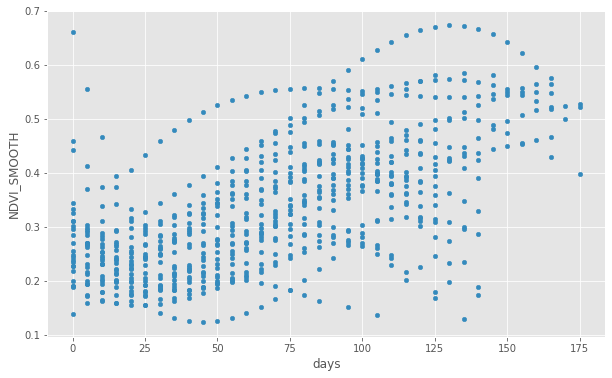

In [846]:
st_f = []
opti = []
ndvi_dd = 0
aoi_df = aoi_df_1.copy()
fig, ax = plt.subplots(figsize = (10,6), facecolor = 'white')
for i in aoi_df.index:
    fid = aoi_df['fid'][i]
    AOI = aoi_df['AOI'][i]
    sowing = aoi_df['sow_date'][i]
    harvesting = aoi_df['harvest_date_2'][i]
    try : 
        tomato_farm = get_mean_ndvi(AOI, sowing, harvesting)
        tomato_farm['days'] = [(x - tomato_farm.date[0]).days 
                               for x in tomato_farm.date]
            

            
        #if (tomato_farm.NDVI_SMOOTH[0] < 0.3)  :

        tomato_farm.plot.scatter('days', 'NDVI_SMOOTH', ax = ax)

        st_f.append(tomato_farm[['days','NDVI_SMOOTH']])
        opti.append(fid)
           
            #plt.savefig(f'/home/satyukt/Projects/5020/visual/ndvi/seed type/{name}.png')
            

    except :
        pass
plt.show()

# Formula

In [856]:
def avg(optimal_df, pixel_df, area = None, yield_farm = 20/0.558):
    
    
    days =  pixel_df.days.max()
    optimal_df = optimal_df[optimal_df.days <= days]
    
    

    pixel_df['Difference'] = 1 - ((optimal_df['Optimal_Ndvi'] - pixel_df['NDVI_SMOOTH'])/optimal_df['Optimal_Ndvi'])
     
    opti_area = 0.558
    
    
    
    af = opti_area/area
    
    
    yiel = pixel_df['Difference'].mean() * yield_farm 
    
    dif =  yiel - yield_farm
    
    return round(yiel,2)

## YIELD PREDICTION BEFORE APRIL 25TH 

- with one optimal farm for both chilli and tomato

In [858]:
aoi_df_3 = aoi_df_1.copy()
data = pd.read_csv('/home/satyukt/Projects/5020/data/info/all_info.csv')
if crop == 'Tomato':
    optimal_ndvi = pd.read_csv('/home/satyukt/Projects/5020/data/optimal/68517_tomato.csv')
else:
    optimal_ndvi = pd.read_csv('/home/satyukt/Projects/5020/data/optimal/68731_chilli.csv')
st = []
for i in aoi_df_3.index.values:
    AOI = aoi_df_3['AOI'][i]
    sowing = aoi_df_3['sow_date'][i]
    harvesting = aoi_df_3['harvest_date_1'][i]
    if aoi_df_3['fid'][i] != 685199.0:
        try : 
            
            tomato_farm = get_mean_ndvi(AOI, sowing, harvesting)
            tomato_farm['days'] = [(x - tomato_farm.date[tomato_farm.index[0]]).days 
                                   for x in tomato_farm.date]

            fid = aoi_df_3['fid'][i]
            
            area = data.loc[data.fid == aoi_df.fid[i], 'Sat2Farm (acres)'].values[0]
            
            tomato_farm = inter_pol(tomato_farm)
            
            yield_da = avg(optimal_ndvi, tomato_farm, area, yield_farm = 2.5/0.5115)
            
            print(f"farmid = {fid}\n")
            print(f"yield predicted:{yield_da}\n")
            print('*' *  25)
            st.append([fid, yield_da])
            
            
            #fig, ax = plt.subplots(figsize = (10,6), facecolor = 'white')
            # tomato_farm.plot('days','NDVI_SMOOTH', ax = ax)
            #plt.title(f"ind = {i}, fid = {fid}, Name = {name}")


        except Exception as e:
            print(e)


farmid = 68376

yield predicted:3.41

*************************
farmid = 68519

yield predicted:3.52

*************************
farmid = 68752

yield predicted:5.41

*************************
farmid = 68765

yield predicted:4.96

*************************
farmid = 68513

yield predicted:4.11

*************************
farmid = 68400

yield predicted:3.5

*************************
farmid = 68514

yield predicted:4.22

*************************
farmid = 68719

yield predicted:2.9

*************************
farmid = 68518

yield predicted:3.46

*************************
farmid = 68517

yield predicted:3.46

*************************
farmid = 68727

yield predicted:3.23

*************************
farmid = 68372

yield predicted:4.1

*************************
farmid = 68398

yield predicted:4.1

*************************
farmid = 68377

yield predicted:4.06

*************************
farmid = 68403

yield predicted:3.2

*************************
farmid = 68406

yield predicted:3.95

*******

# YIELD PREDICTION After APRIL 25TH 

- with one optimal farm for both chilli and tomato

In [860]:
aoi_df_3 = aoi_df_1.copy()
data = pd.read_csv('/home/satyukt/Projects/5020/data/info/all_info.csv')
if crop == 'Tomato':
    optimal_ndvi = pd.read_csv('/home/satyukt/Projects/5020/data/optimal/68517_tomato.csv')
else:
    optimal_ndvi = pd.read_csv('/home/satyukt/Projects/5020/data/optimal/68731_chilli.csv')
    
st2 = []
for i in aoi_df_3.index.values:
    AOI = aoi_df_3['AOI'][i]
    sowing = aoi_df_3['sow_date'][i]
    harvesting = aoi_df_3['harvest_date_2'][i]
    if aoi_df_3['fid'][i] != 685199:
        try : 
            
            tomato_farm = get_mean_ndvi(AOI, sowing, harvesting)
            tomato_farm['days'] = [(x - tomato_farm.date[tomato_farm.index[0]]).days 
                                   for x in tomato_farm.date]

            fid = aoi_df_3['fid'][i]
            name = data.loc[data['fid']== fid, 'Name'].values[0]
            area = data.loc[data.fid == aoi_df.fid[i], 'Sat2Farm (acres)'].values[0]
            
            tomato_farm = inter_pol(tomato_farm)
            
            yield_da = avg(optimal_ndvi, tomato_farm, area, yield_farm =  2.5/0.5115)
            
            print(f"farmid = {fid}\n")
            print(f"yield predicted:{yield_da}\n")
            print('*' *  25)
            st2.append([fid, yield_da])
            
            #fig, ax = plt.subplots(figsize = (10,6), facecolor = 'white')
            # tomato_farm.plot('days','NDVI_SMOOTH', ax = ax)
            #plt.title(f"ind = {i}, fid = {fid}, Name = {name}")


        except Exception as e:
            print(e)


farmid = 68376

yield predicted:3.86

*************************
farmid = 68519

yield predicted:3.42

*************************
farmid = 68752

yield predicted:5.46

*************************
farmid = 68765

yield predicted:4.89

*************************
farmid = 68513

yield predicted:3.96

*************************
farmid = 68400

yield predicted:3.45

*************************
farmid = 68514

yield predicted:4.01

*************************
farmid = 68719

yield predicted:2.97

*************************
farmid = 68518

yield predicted:3.17

*************************
farmid = 68517

yield predicted:3.26

*************************
farmid = 68727

yield predicted:3.53

*************************
farmid = 68372

yield predicted:3.38

*************************
farmid = 68398

yield predicted:3.51

*************************
farmid = 68377

yield predicted:4.09

*************************
farmid = 68403

yield predicted:3.35

*************************
farmid = 68406

yield predicted:3.85

**

In [861]:
bf = pd.DataFrame(st, columns = ['fid', 'Yield(Tonnes/Acre) (before)'])
af = pd.DataFrame(st2, columns = ['fid', 'Yield(Tonnes/Acre) (after)'])
dt = bf.merge(af, on = 'fid')
dt = dt.merge(data[['fid', 'Name']], on = 'fid')
dt['Difference in Yield'] = dt['Yield(Tonnes/Acre) (before)'] - dt['Yield(Tonnes/Acre) (after)']
dt = dt[['fid','Name', 'Yield(Tonnes/Acre) (before)','Yield(Tonnes/Acre) (after)', 'Difference in Yield']]

## NDVI METHOD For Tomato

In [867]:
df = pd.read_csv('/home/satyukt/Projects/5020/data/info/all_info.csv')

crop = 'Tomato'


df = df[df['Crop'] == crop ]
df.head()

,fid,Name,Crop,Sat2Farm (acres),Seed details,Soil type,sowingdt,Yield,geometry,min days,max days
1,68519,allouri Sri Latha,Tomato,0.5580,General,Silt,2022-12-10,20,"[[[78.755714, 18.0789007], [78.755729, 18.0789...",90,145
4,68513,Enti Mallavva,Tomato,0.4713,US800 F1 hybrid,Silt,2023-01-12,10,"[[[78.7580773, 18.0691505], [78.7581004, 18.06...",100,145
5,68400,Erra mallavva,Tomato,0.8797,US440,silt,2023-02-23,12.5,"[[[78.7638542, 18.0760676], [78.763875, 18.076...",90,130
6,68514,Jangam Llavva,Tomato,1.9180,Syngenta,sandy loam,2023-02-09,10,"[[[78.7556683, 18.0658269], [78.7556455, 18.06...",80,130
8,68518,keadari balreddy,Tomato,0.7575,General,sandy loam,2023-01-20,7.5,"[[[78.7530417, 18.0772445], [78.7530277, 18.07...",90,145


In [868]:
rows = []
for i in df.index:
    
    date = datetime.strptime(df.loc[i].sowingdt, "%Y-%m-%d")
    sow_date = (date
                -timedelta(days = 15)).strftime("%Y-%m-%d")
    
    
   
    har = df['max days '][i]
    harvest_date_2 = (date
                    -timedelta(days = 15)
                    +timedelta(days = int(har))).strftime("%Y-%m-%d")
    
    harvest_date = '2023-04-25'
    
    AOI = ee.Geometry.Polygon(eval(df.loc[i].geometry))
    rows.append({'fid':df.fid[i],
                'sow_date' : sow_date, 
                 'harvest_1':harvest_date, 
                 'harvest_date':harvest_date_2,
                 'AOI' : AOI,
                'seed details':df['Seed details'][i]})
aoi_df = pd.DataFrame.from_dict(rows)
aoi_df['seed details'] = aoi_df_1['seed details'].fillna(0)
aoi_df

,fid,sow_date,harvest_1,harvest_date,AOI,seed details
0,68519,2022-11-25,2023-04-25,2023-04-19,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
1,68513,2022-12-28,2023-04-25,2023-05-22,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
2,68400,2023-02-08,2023-04-25,2023-06-18,"ee.Geometry({\n ""functionInvocationValue"": {\...",Ujala
3,68514,2023-01-25,2023-04-25,2023-06-04,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
4,68518,2023-01-05,2023-04-25,2023-05-30,"ee.Geometry({\n ""functionInvocationValue"": {\...",US800 F1 hybrid
5,68517,2023-01-19,2023-04-25,2023-06-13,"ee.Geometry({\n ""functionInvocationValue"": {\...",US440
6,68372,2023-01-21,2023-04-25,2023-06-10,"ee.Geometry({\n ""functionInvocationValue"": {\...",Syngenta
7,68398,2023-01-22,2023-04-25,2023-06-01,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
8,68377,2023-01-23,2023-04-25,2023-06-02,"ee.Geometry({\n ""functionInvocationValue"": {\...",General
9,68403,2022-11-27,2023-04-25,2023-04-06,"ee.Geometry({\n ""functionInvocationValue"": {\...",General


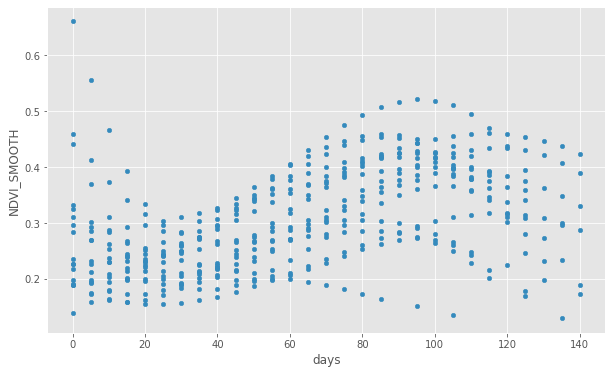

In [869]:
st_f = []
opti = []
fig, ax = plt.subplots(figsize = (10,6), facecolor = 'white')
for i in aoi_df.index:
    fid = aoi_df['fid'][i]
    AOI = aoi_df['AOI'][i]
    sowing = aoi_df['sow_date'][i]
    harvesting = aoi_df['harvest_date'][i]
    try : 
        tomato_farm = get_mean_ndvi(AOI, sowing, harvesting)
        tomato_farm['days'] = [(x - tomato_farm.date[0]).days 
                               for x in tomato_farm.date]
            

            
        if (tomato_farm.NDVI_SMOOTH[0]  <0.7) :

            tomato_farm.plot.scatter('days', 'NDVI_SMOOTH', ax = ax)

            st_f.append(tomato_farm['NDVI_SMOOTH'].values)
            opti.append(fid)
           
            

    except :
        pass
plt.show()

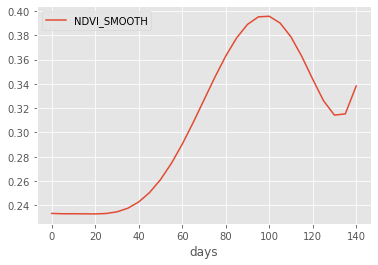

In [871]:
optimal = pd.DataFrame(st_f)
d = {}
columns = optimal.columns
for i in columns:
    d[i] = np.nanmedian(optimal[i])
optima = pd.DataFrame([d]).T
optima.columns = ['Ndvi']
optima['days'] = [x*5 for x in range(len(optima)) ]
optima['Ndvi'] = smooth_6(optima['Ndvi'].values)
optima = optima.rename(columns = {'Ndvi': 'NDVI_SMOOTH'})
optima.plot('days', 'NDVI_SMOOTH')
optima_inter = inter_pol(optima)

In [131]:
def cond(df):
    optima_inter = inter_pol(df)
    max_ind = optima_inter.loc[optima_inter['NDVI_SMOOTH'] == optima_inter['NDVI_SMOOTH'].max()].index.values[0]
    conditions = [(optima_inter['days'] <= max_ind/2),
    (optima_inter['days'] > max_ind/2) & (optima_inter['days'] <=max_ind),
    (optima_inter['days'] > max_ind)]
    choices = ['Phase-1', 'Phase-2', 'Phase-3']
    
    optima_inter['Phase'] = np.select(conditions, choices)
    
    return optima_inter
    

In [875]:
optimal = pd.read_csv('/home/satyukt/Projects/5020/data/optimal/optimal_tomato.csv')
phase_val = {'Phase-1':0.2,'Phase-2':0.3, 'Phase-3':0.5 }
df2 = pd.read_csv('/home/satyukt/Projects/5020/data/info/all_info.csv')
df2.head()

,fid,Name,Crop,Sat2Farm (acres),Seed details,Soil type,sowingdt,Yield,geometry,min days,max days
0,68376,addala venktramreddy,Chili,0.7297,General,silt,2023-01-26,None,"[[[78.8501505, 18.1611839], [78.8501688, 18.16...",160,180
1,68519,allouri Sri Latha,Tomato,0.5580,General,Silt,2022-12-10,20,"[[[78.755714, 18.0789007], [78.755729, 18.0789...",90,145
2,68752,Bejagam Srinivas,Chili,0.8714,Ujala,sandy loam,2022-12-16,10,"[(78.8379724, 18.2117596), (78.8379852, 18.211...",150,170
3,68765,dedduda narshumulu,Chili,0.7204,General,Silt soil,2022-12-12,2.5,"[(78.83483693003654, 18.159266303158834), (78....",160,180
4,68513,Enti Mallavva,Tomato,0.4713,US800 F1 hybrid,Silt,2023-01-12,10,"[[[78.7580773, 18.0691505], [78.7581004, 18.06...",100,145


In [883]:

for i in aoi_df.index:
    fid = aoi_df['fid'][i]
    AOI = aoi_df['AOI'][i]
    sowing = aoi_df['sow_date'][i]
    harvesting = aoi_df['harvest_date'][i]
    try : 
        tomato_farm = get_mean_ndvi(AOI, sowing, harvesting)
        tomato_farm['days'] = [(x - tomato_farm.date[0]).days 
                               for x in tomato_farm.date]
        
        area, yiel =  df2.loc[df2.fid == int(fid), ['Sat2Farm (acres)', 'Yield']].values[0]
        
        if (tomato_farm.NDVI_SMOOTH[0]  <0.3) & (yiel != 'None'):
            tomato_farm = cond(tomato_farm)


            val = []
            for i in ['Phase-1', 'Phase-2', 'Phase-3']:
                farm = tomato_farm[tomato_farm['Phase'] == i]
                days = farm.days.max()
                opti = optimal[optimal['Phase']==i]
                opti = opti[opti['days']<=days]

                farm['Difference'] = 1 - ((opti['NDVI_SMOOTH'] - farm['NDVI_SMOOTH'])/opti['NDVI_SMOOTH'])

                mean = farm['Difference'].mean()
                val.append( mean * phase_val[i])
            
            
            yied_pred = float(yiel) * sum(val)
                
            print(f" Farm_id = {fid}, yield = {round(yied_pred,2)} Yield(Tonnes), previous = {float(yiel)} Yield(Tonnes)")
        
        
    except Exception as e:
        print(e)
        


 Farm_id = 68519, yield = 22.3 Yield(Tonnes), previous = 20.0 Yield(Tonnes)
 Farm_id = 68513, yield = 11.39 Yield(Tonnes), previous = 10.0 Yield(Tonnes)
 Farm_id = 68514, yield = 10.99 Yield(Tonnes), previous = 10.0 Yield(Tonnes)
 Farm_id = 68517, yield = 8.05 Yield(Tonnes), previous = 8.0 Yield(Tonnes)
 Farm_id = 68377, yield = 10.29 Yield(Tonnes), previous = 8.75 Yield(Tonnes)
 Farm_id = 68403, yield = 7.35 Yield(Tonnes), previous = 7.5 Yield(Tonnes)
 Farm_id = 68406, yield = 16.97 Yield(Tonnes), previous = 13.75 Yield(Tonnes)
 Farm_id = 68526, yield = 12.45 Yield(Tonnes), previous = 15.0 Yield(Tonnes)
 Farm_id = 68405, yield = 20.64 Yield(Tonnes), previous = 25.0 Yield(Tonnes)
 Farm_id = 68515, yield = 20.44 Yield(Tonnes), previous = 20.0 Yield(Tonnes)
 Farm_id = 68528, yield = 8.79 Yield(Tonnes), previous = 7.0 Yield(Tonnes)


# Sensor Data Model

In [347]:
def files_path(path, in1= None):
    files = glob.glob(path)
    st = []
    for fil in files:
        df = format_df(pd.read_csv(fil))
        st.append(df)
    df = pd.concat(st, axis=1)
    df = df.loc[:,~df.columns.duplicated()].copy()
    df = df.rename(columns = {'Date time (time zone: Asia/Kolkata)':'date'})
    df = df.dropna()
    df['days'] = [int((x - df.date[df.index[0]]).days) 
                                       for x in df.date]
        
    #X = df_final[in1].values
    return df 


def format_df(df):
    
    df['date'] = df['Date time (time zone: Asia/Kolkata)'].apply(
        lambda x : format_date(x))
    
    
    df = df.groupby('date').mean()
    
    df = df.reset_index().iloc[:,:]
    
    
    
    df['days'] = [int((x - df.date[df.index[0]]).days) 
                                       for x in df.date]
    
    return df


def format_date(x):
    try:
        date = dt.datetime.strptime(' '.join(x.split(' ')
                                  [:-2]),'%B %d, %Y').strftime('%Y-%m-%d')
        
        return pd.to_datetime(date)
    except Exception as e:
        print(e)
        


In [848]:
client = pd.read_csv('../data/info/all_info.csv')

In [849]:
def phases(df):
    conditions = [(df['days'] <= 10),
    (df['days'] >10) & (df['days'] <= 30),
    (df['days'] >30) & (df['days'] <= 90),
    (df['days'] > 90)]
    choices = ['Phase-1', 'Phase-2', 'Phase-3', 'Phase-4']
    df['Phase'] = np.select(conditions, choices)
    return df

In [884]:
def formul(val, mean):
    
    cal = 1 - ((val- mean) /val)
    
    return cal 
    

def sensor_model(repo, yied):   
    data3 = pd.read_csv(repo) 
    data3['date'] = data3['Date time (time zone: Asia/Kolkata)'].apply(lambda x : format_date(x))
    data3['days'] = [int((x - data3.date[data3.index[0]]).days) 
                                           for x in data3.date]
    data3 = data3[data3['Temperature (°C)']!= '-']
    data3['Temperature (°C)'] = data3['Temperature (°C)'].astype('float')
    data3['Humidity (%)'] = data3['Humidity (%)'].astype('float')
    data3 = data3.loc[data3['Soil temperature (°C)']!= '-']
    data3['Soil temperature (°C)'] = data3['Soil temperature (°C)'].astype('float')
    data3 = data3.groupby('days').mean()
    data3 = data3.reset_index()
    data3['Binary_lw'] = [1 if x>0 else 0 for x in data3['Leaf wetness (%)']]
    # temp = data3[['days', 'Temperature (°C)']]
    data3 = phases(data3)

    dic = {'Temperature (°C)':[[15,30],[18,32], [15,32], [20,30]],
          'Humidity (%)':[[40,75], [40,90], [40,90], [40,85]], 
          'Soil temperature (°C)':[[20,34],[20,34], [20,36], [20,36]]}
    
    

    in1 = ['Temperature (°C)', 'Humidity (%)', 'Soil temperature (°C)']

    st = []
    for ind, i in enumerate(['Phase-1','Phase-2', 'Phase-3', 'Phase-4']):

        test = data3.loc[data3['Phase'] == i]
        for i in in1:
            val = np.mean(dic[i][ind]) 
            cal = formul(val, test[i].mean())
            st.append(cal)
    return np.mean(st) * float(yied)

In [890]:

farm_ids = client.loc[client.Crop == 'Tomato']['fid'].tolist()

for fi in farm_ids:
    try:
        yied = client.loc[client['fid']==fi, 'Yield'].values[0]
        repo = f'/home/satyukt/Projects/5020/data/updated_details/{fi}/report.csv'
        print(f'farm id = {fi} Yield =  {round(sensor_model(repo, float(yied)), 2)} Tonnes, Excepted = {yied}')
    except:
        pass
        

farm id = 68519 Yield =  19.78 Tonnes, Excepted = 20
farm id = 68513 Yield =  10.01 Tonnes, Excepted = 10
farm id = 68400 Yield =  12.38 Tonnes, Excepted = 12.5
farm id = 68514 Yield =  9.81 Tonnes, Excepted = 10
farm id = 68518 Yield =  7.39 Tonnes, Excepted = 7.5
farm id = 68517 Yield =  nan Tonnes, Excepted = 8
farm id = 68372 Yield =  8.63 Tonnes, Excepted = 8.75
farm id = 68377 Yield =  8.83 Tonnes, Excepted = 8.75
farm id = 68403 Yield =  7.37 Tonnes, Excepted = 7.5
farm id = 68406 Yield =  13.49 Tonnes, Excepted = 13.75
farm id = 68526 Yield =  14.65 Tonnes, Excepted = 15
farm id = 68405 Yield =  23.97 Tonnes, Excepted = 25
farm id = 68399 Yield =  4.92 Tonnes, Excepted = 5
farm id = 68515 Yield =  19.72 Tonnes, Excepted = 20
farm id = 68528 Yield =  6.86 Tonnes, Excepted = 7
farm id = 68831 Yield =  8.99 Tonnes, Excepted = 8.75
